In [2]:
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout
from keras.layers import LSTM as CSLstM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
from sklearn.metrics import mean_absolute_error
%matplotlib inline

In [3]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=ETH&tsym=USD&limit=500')
hist = pd.DataFrame(json.loads(res.content)['Data'])
hist.to_csv('ethereum.csv')
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

In [4]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [5]:
hist.head(5)

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2020-11-12,470.40,452.69,463.91,419454.50,1.931842e+08,462.78
2020-11-13,477.97,458.10,462.78,408493.75,1.913937e+08,476.87
2020-11-14,477.76,452.26,476.87,303539.72,1.404651e+08,461.03
2020-11-15,463.02,440.46,461.03,256400.31,1.158410e+08,448.51
2020-11-16,471.55,458.84,448.45,662300.65,3.053277e+08,461.01


In [6]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [7]:
train, test = train_test_split(hist, test_size=0.2)

In [8]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [USD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

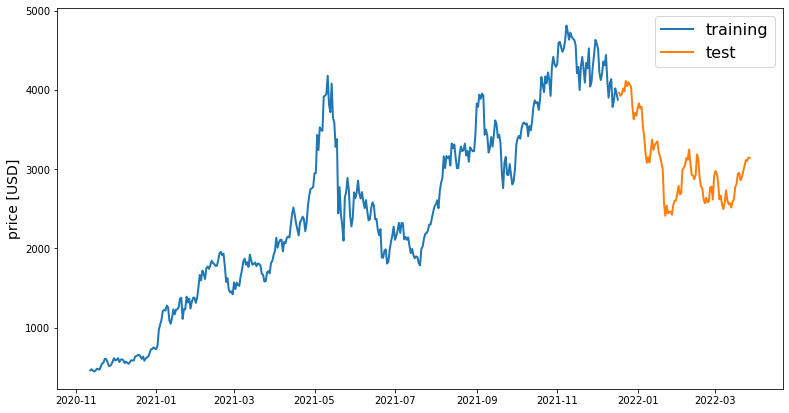

In [9]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [10]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [11]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [12]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.2):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [13]:
def build_lstm_model(input_data, output_size, neurons=100, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(CSLstM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [14]:
np.random.seed(42)
window_len = 5
test_size = 0.2
zero_base = True
lstm_neurons = 100
epochs = 5
batch_size = 32
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [15]:
train, test, X_train, X_test, y_train, y_test = prepare_data(
    hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [16]:
model = build_lstm_model(
    X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,
    optimizer=optimizer)
history = model.fit(
    X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
# save the model to disk
filename = 'ethereum.sav'
pickle.dump(model, open(filename, 'wb'))

Epoch 1/5
13/13 [==============================] - 2s 40ms/step - loss: 0.0102 - val_loss: 0.0052
Epoch 2/5
13/13 [==============================] - 0s 6ms/step - loss: 0.0074 - val_loss: 0.0054
Epoch 3/5
13/13 [==============================] - 0s 6ms/step - loss: 0.0068 - val_loss: 0.0041
Epoch 4/5
13/13 [==============================] - 0s 6ms/step - loss: 0.0065 - val_loss: 0.0046
Epoch 5/5
13/13 [==============================] - 0s 6ms/step - loss: 0.0057 - val_loss: 0.0032


INFO:tensorflow:Assets written to: ram://74e8146f-7784-41f9-96b2-4b95e8a450f1/assets


INFO:tensorflow:Assets written to: ram://74e8146f-7784-41f9-96b2-4b95e8a450f1/assets


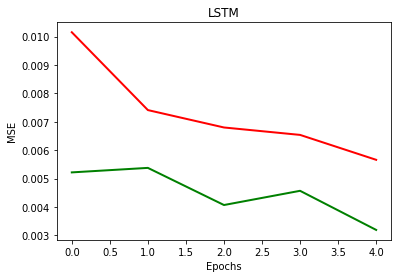

In [17]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [18]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)

0.04393541399858756

In [19]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE


0.003189760936487047

In [20]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.6647865855548282

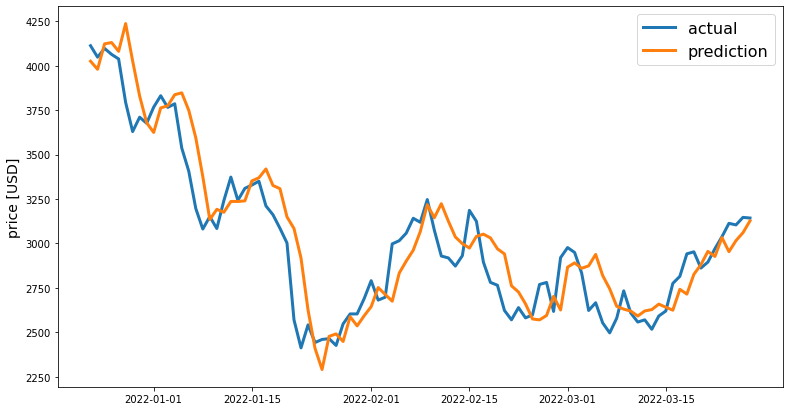

In [21]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

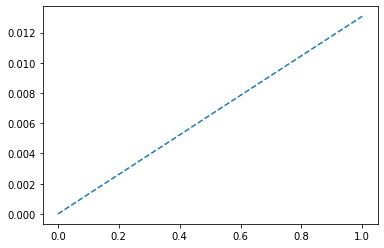

In [23]:
import matplotlib.pyplot as plt
import numpy as np
remove_nan_targets = targets.dropna()
investmentvalue=remove_nan_targets.iloc[0]
oldarray = np.array([0])
for value in remove_nan_targets.items():
    pc=(investmentvalue/value[1])/100
    ypoints = np.append(oldarray, pc)
    
plt.plot(ypoints, linestyle = 'dashed')
plt.show()